In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.models import strong_model_factory, weak_model_factory
from utils.tools import load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic


%load_ext autoreload
%autoreload 2

# Strong Priors

In [2]:
model_data = load_obj('data/bootstrap_data')

yobs = model_data['Yobs']
subject_ids = model_data['subject_ids']
y = model_data['y_est']
times = model_data['times']

with strong_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    strong_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:44<00:00, 180.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:06<00:00, 605.27it/s]


In [3]:
df = pd.DataFrame({'yobs':yobs,
                   'y':y,
                   'times':times,
                   'subject_ids':subject_ids})

predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

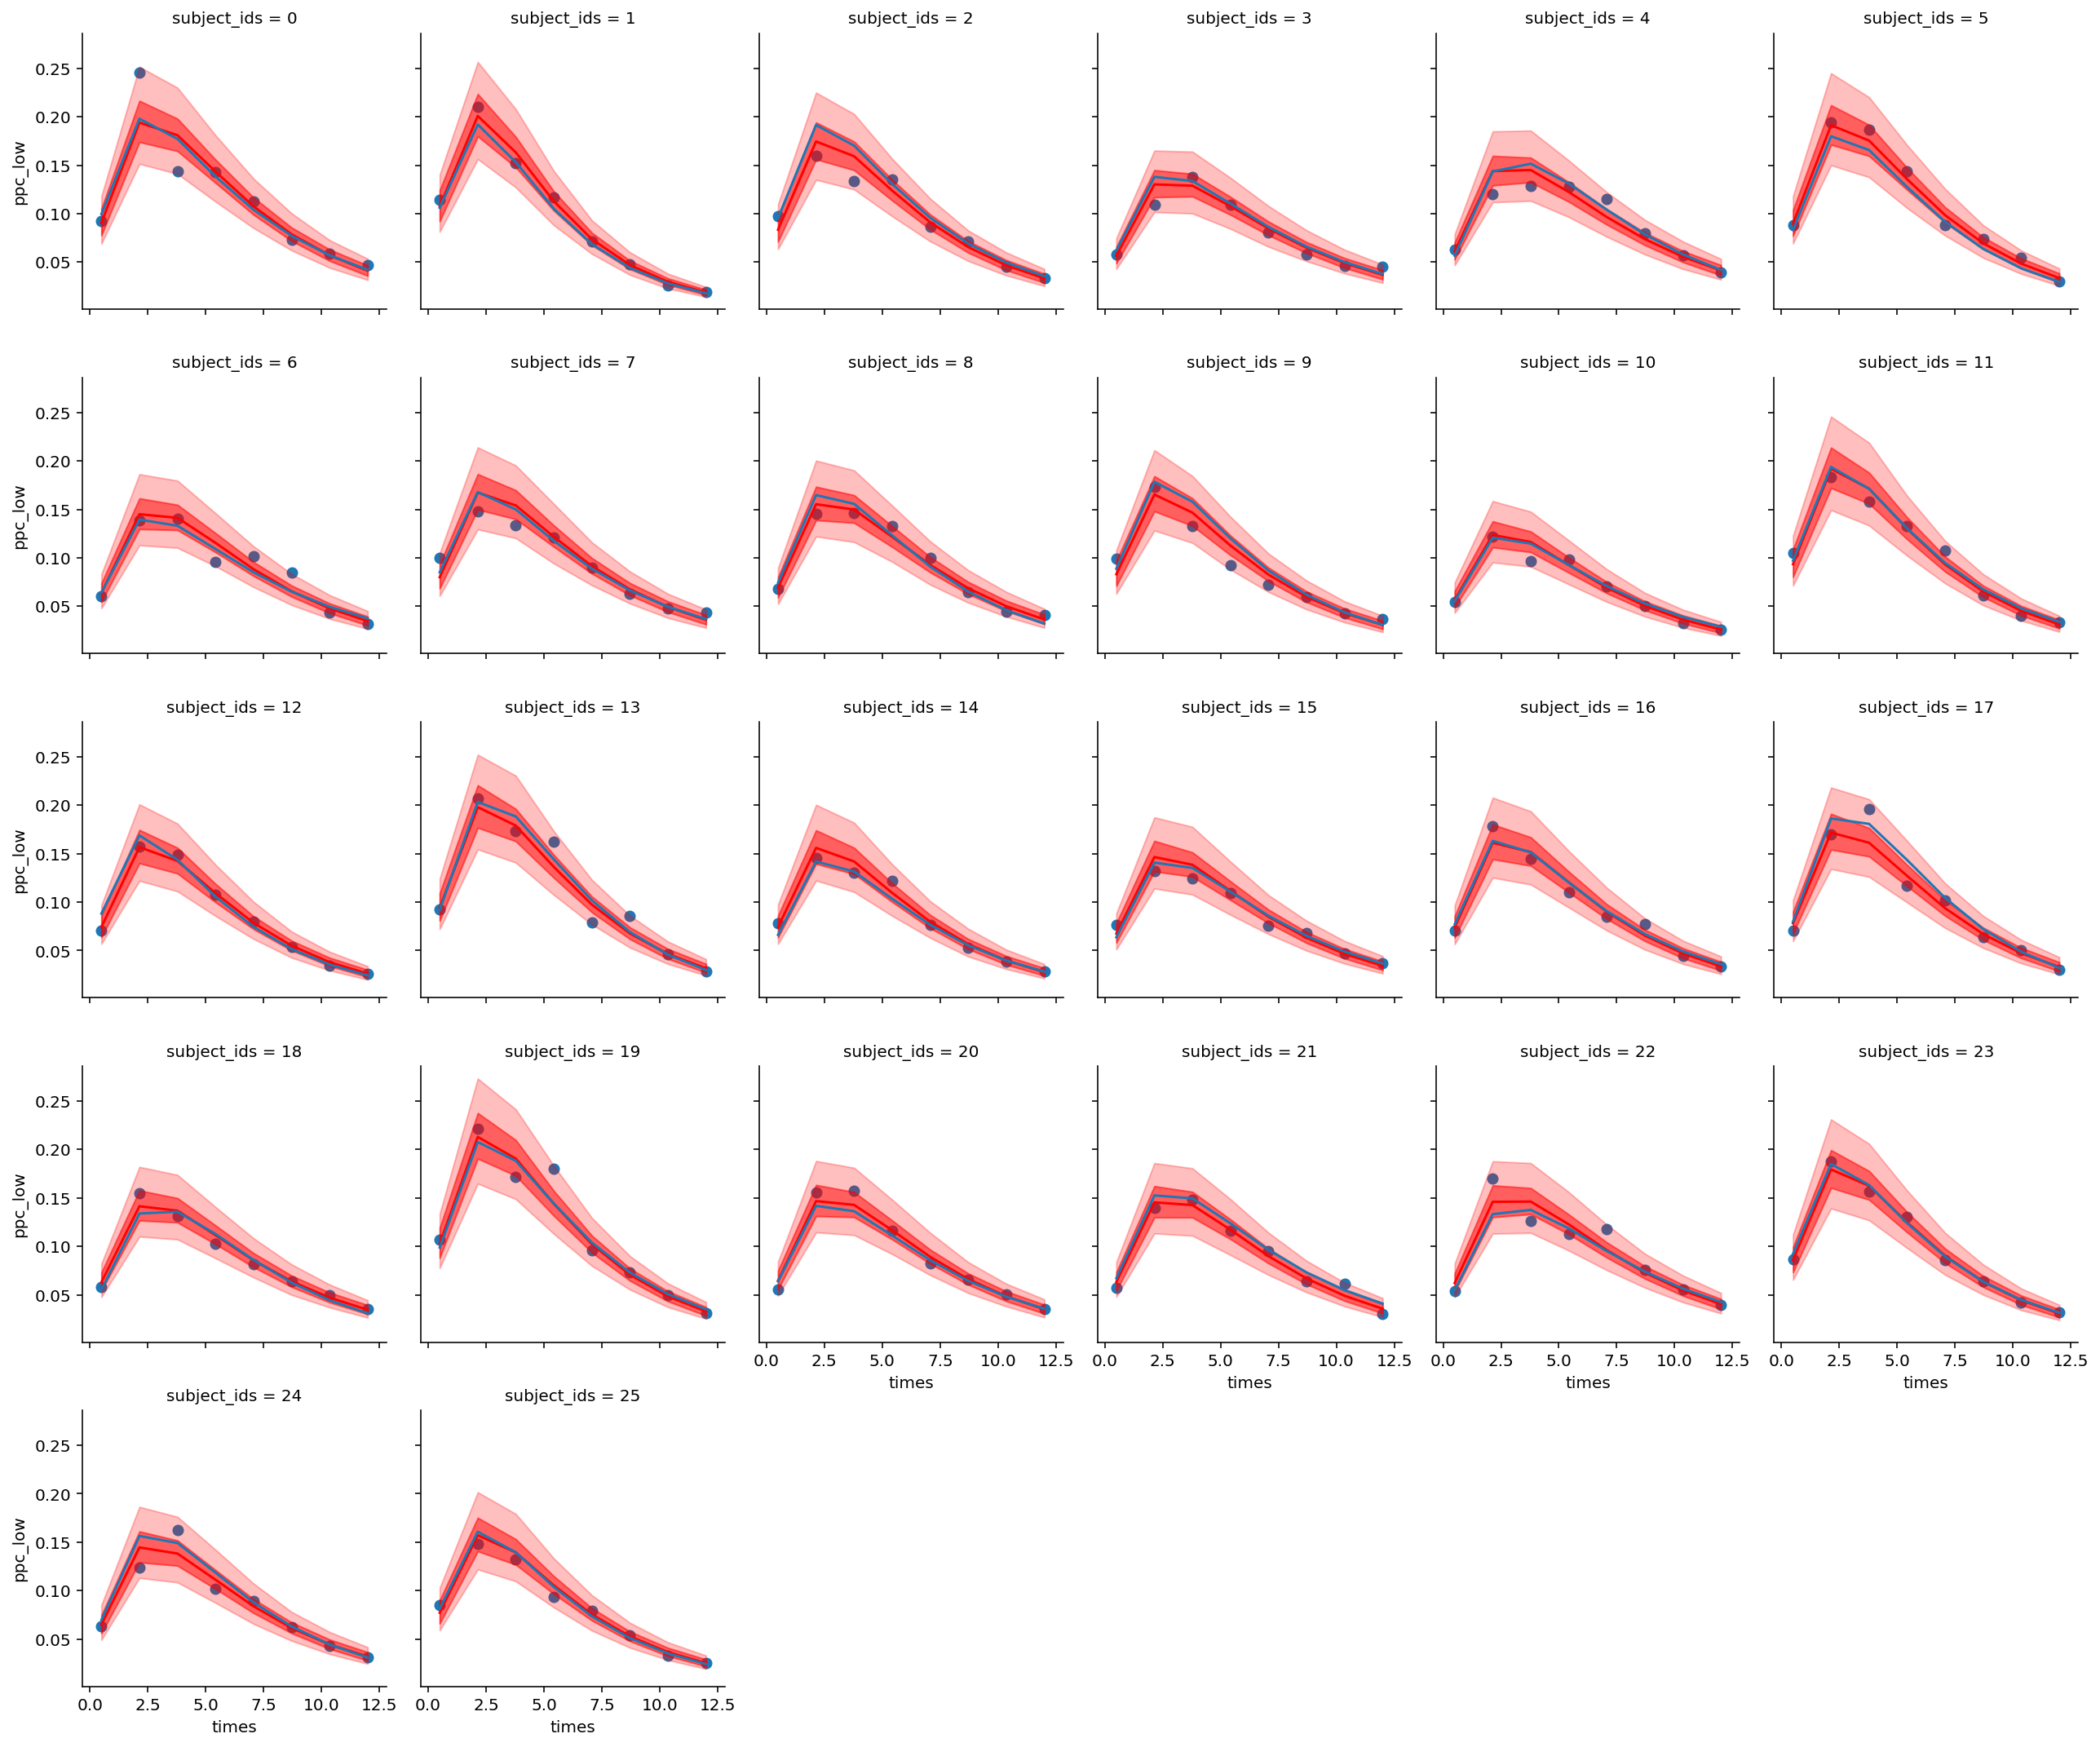

In [4]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'red')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'red')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'red')

# Weak Priors

In [5]:
with weak_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    weak_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
100%|██████████| 4000/4000 [00:09<00:00, 424.77it/s]


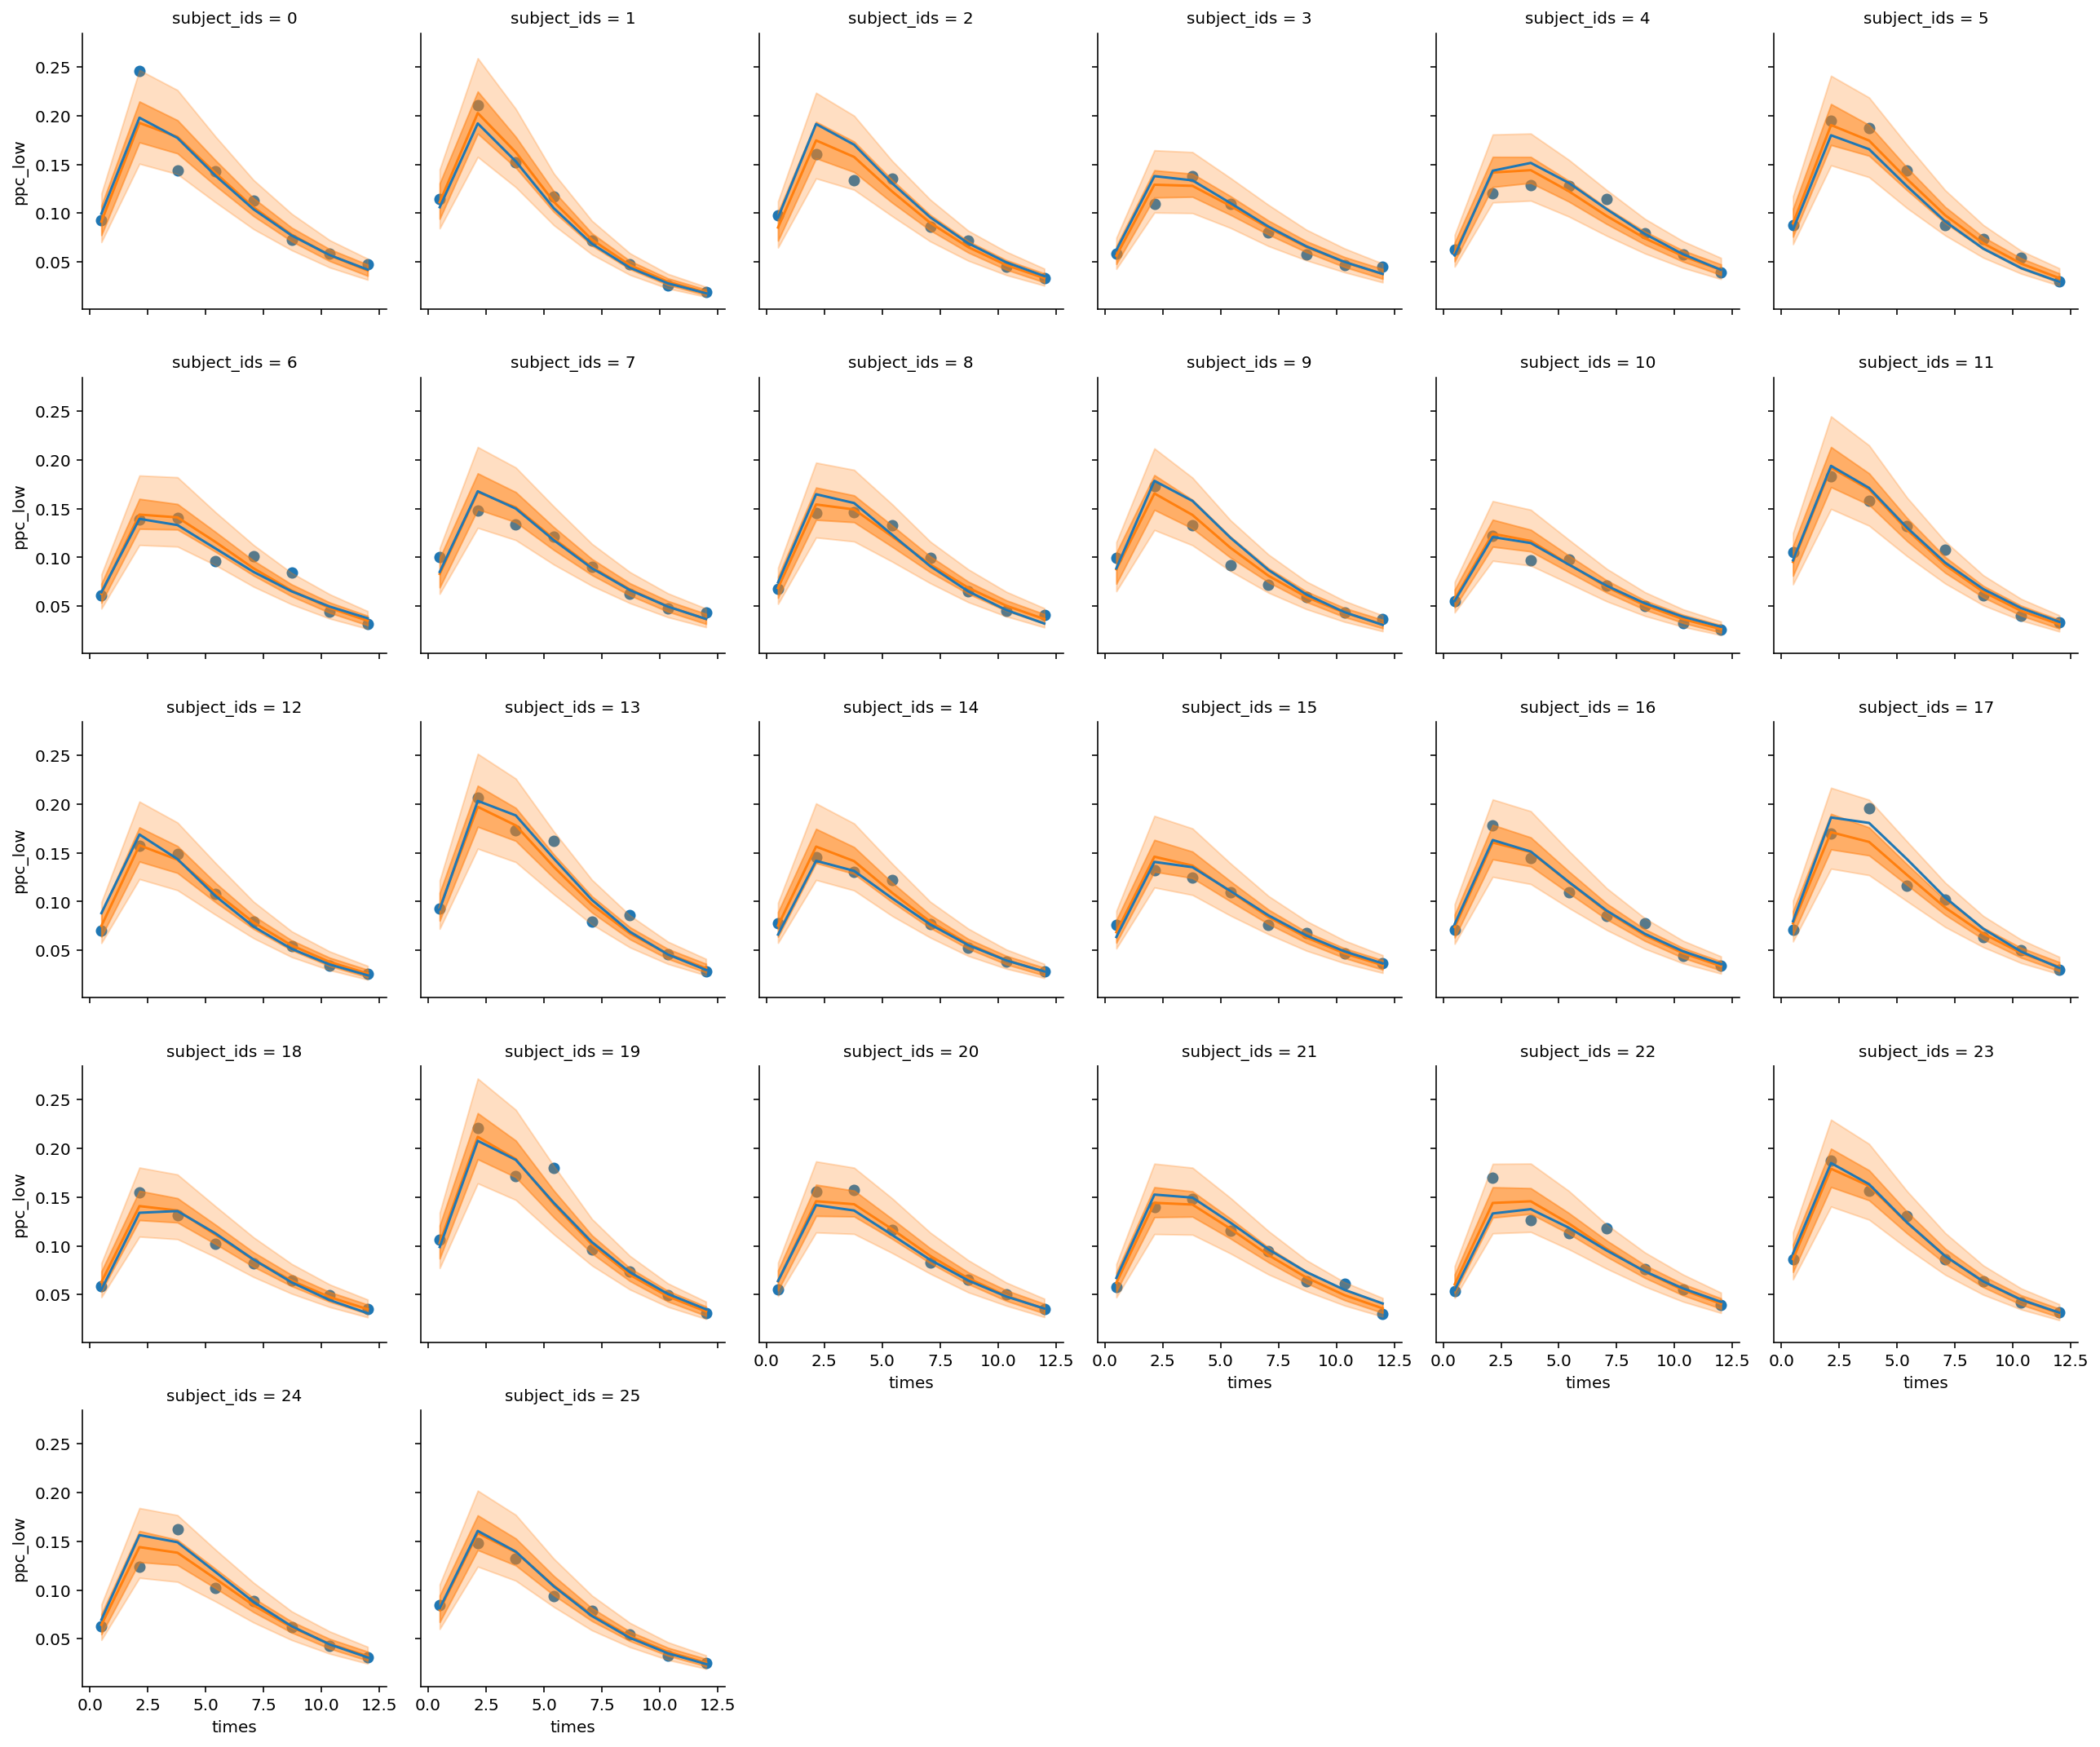

In [6]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

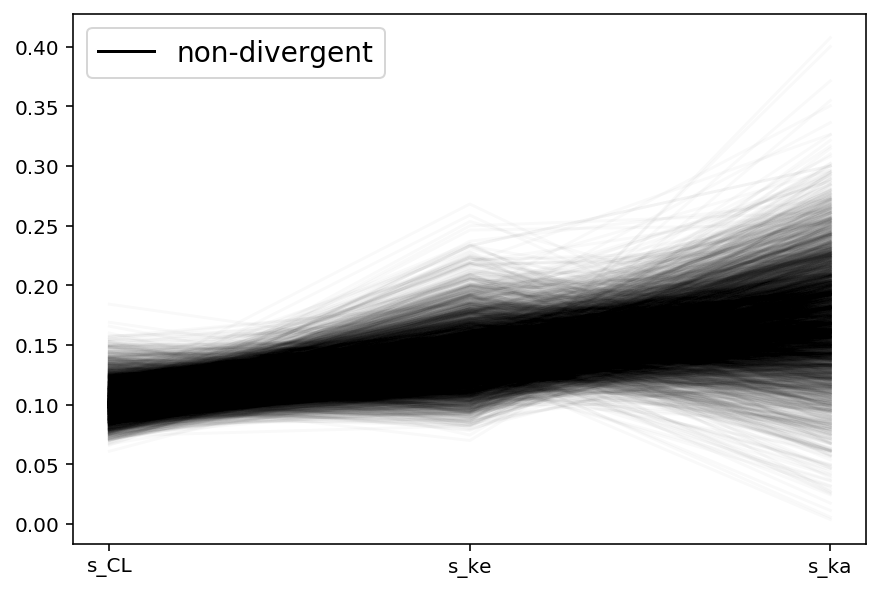

In [7]:
az.plot_parallel(weak_data, var_names=['s_CL','s_ke','s_ka'])

# No random effect in $k_a$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:59<00:00, 133.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 671.25it/s]


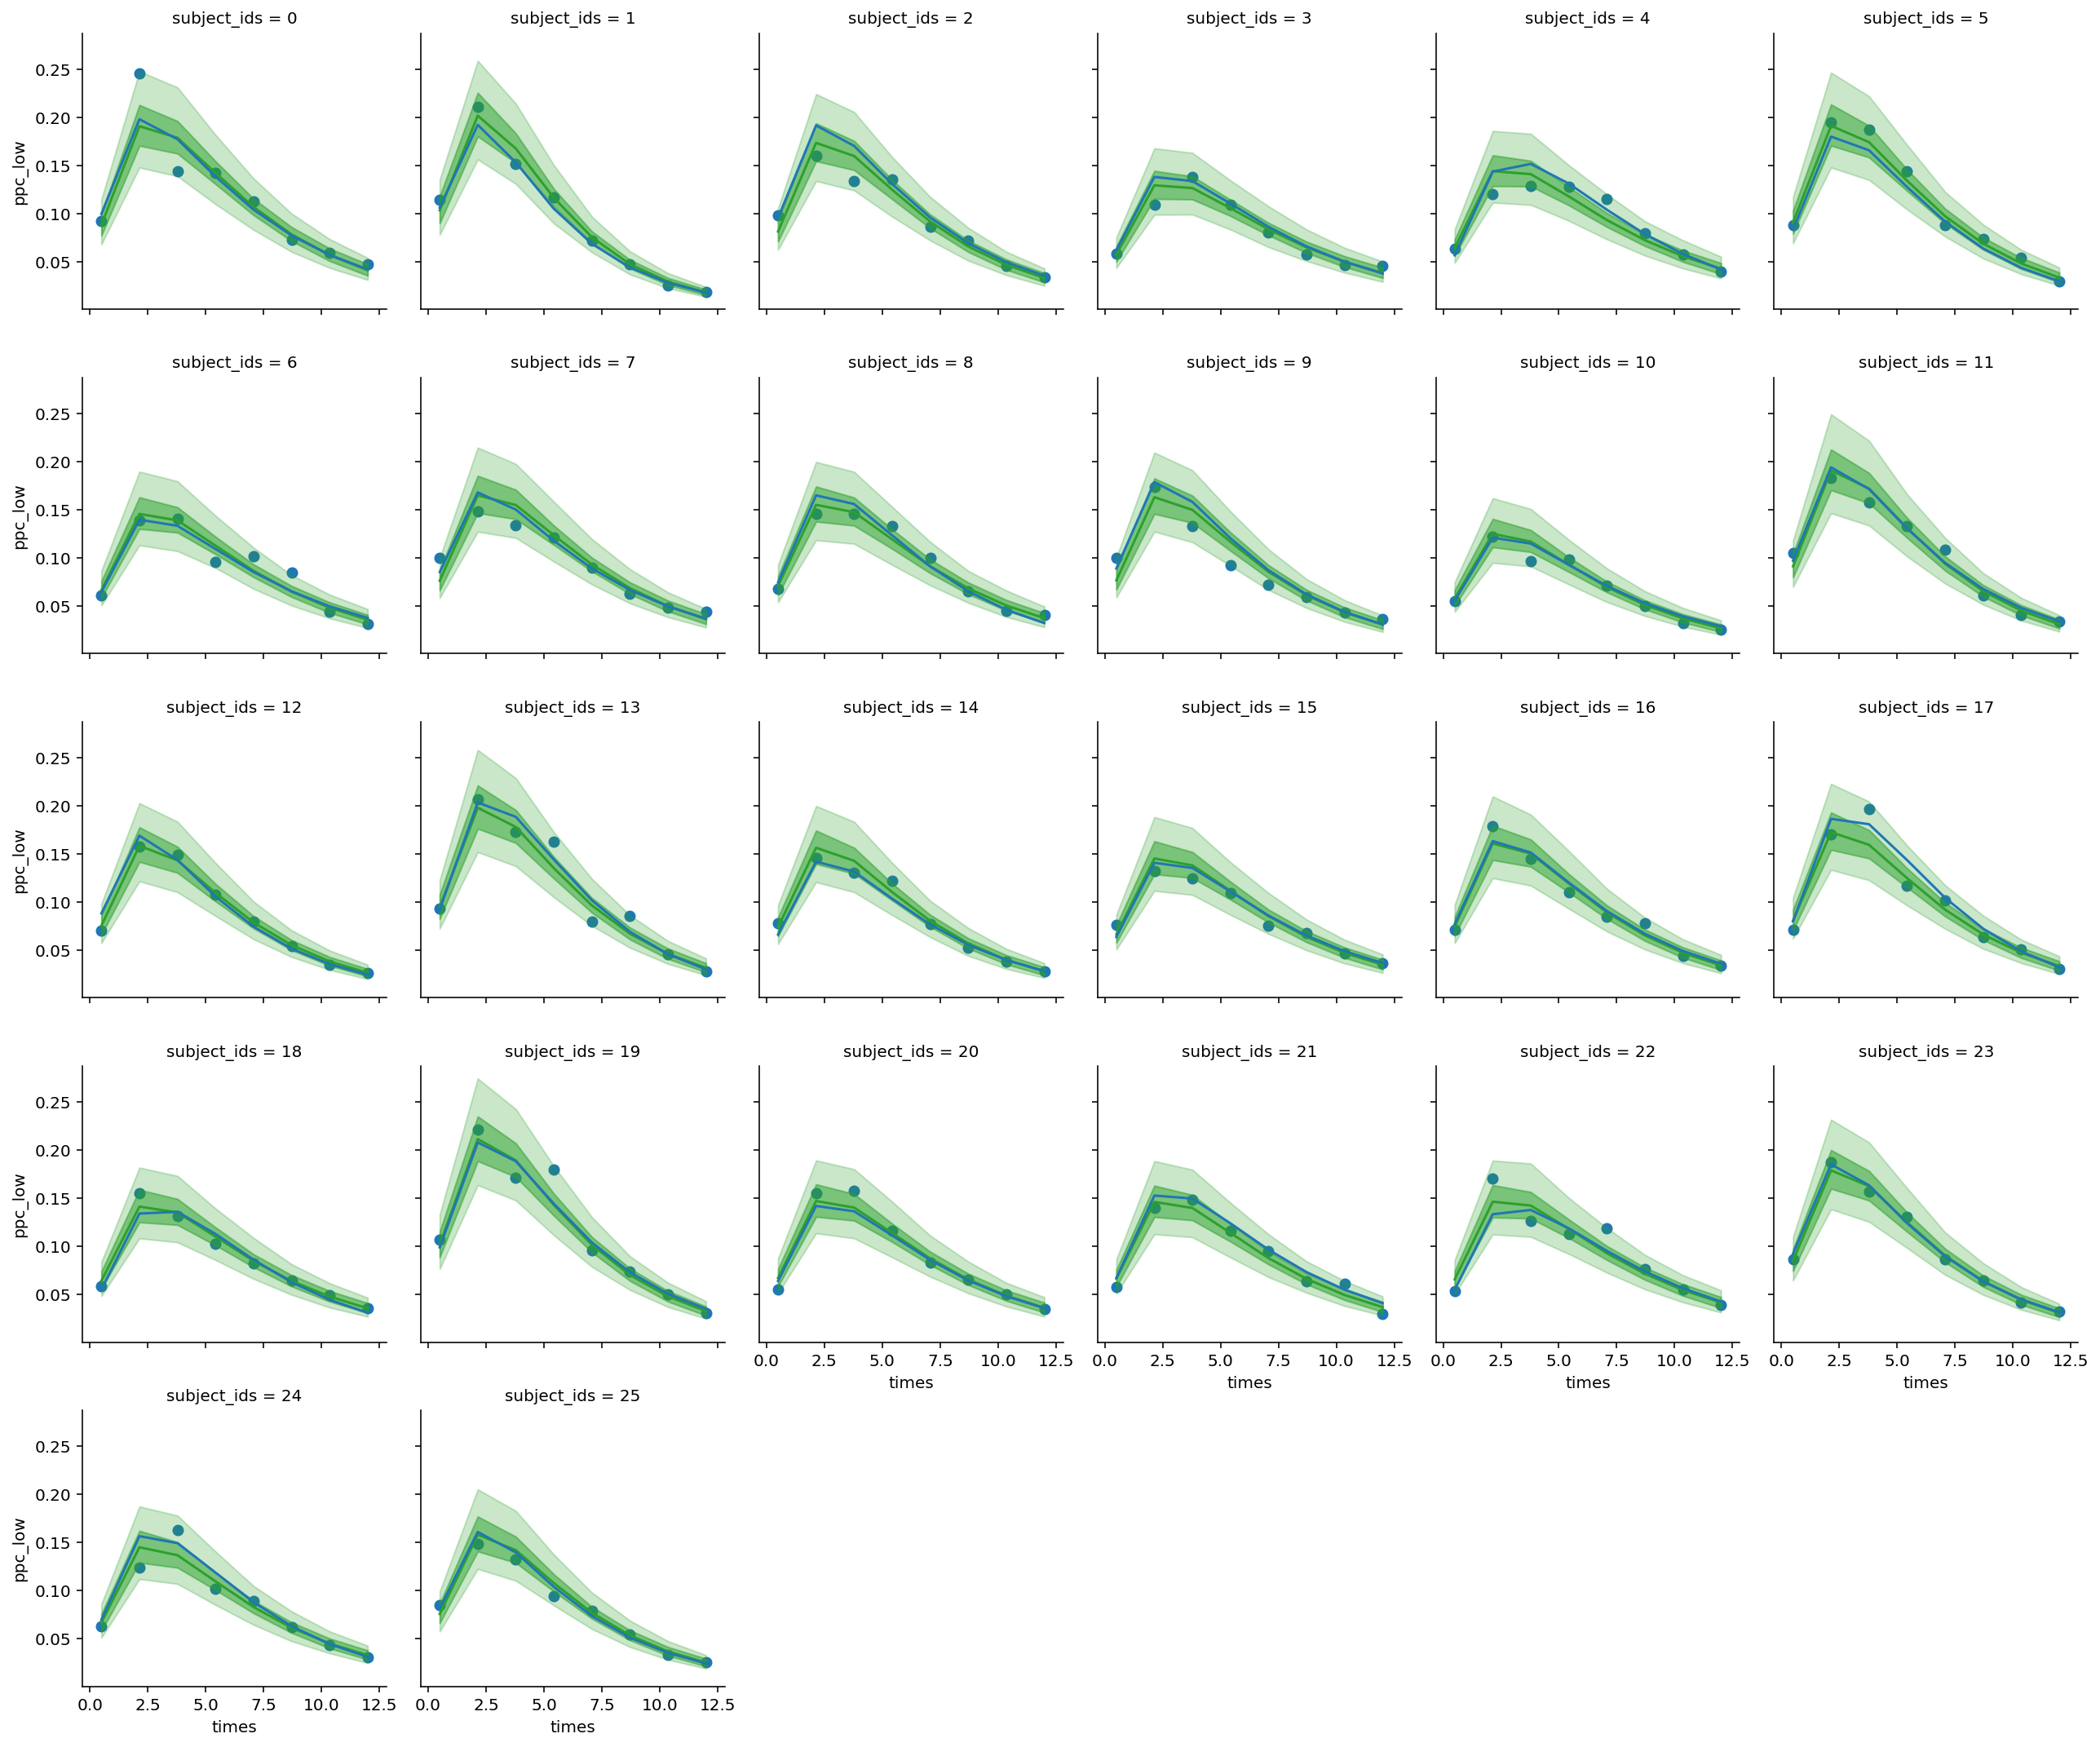

In [8]:
import theano.tensor as tt


def no_rfx_model_factory(Yobs, times, subject_ids):
    """Returns a model context for a weakly informative model.

    Inputs:
    Yobs -- array of observed concentrations at indicated times
    times -- array of observation tiems
    subject_ids -- array of integers used as subject identifiers

    Returns:
    pk_model -- Model context.

    """

    # This is the case when I am simulating from the prior predictive.
    if Yobs is None:
        Yobs = np.zeros_like(times)

    with pm.Model() as pk_model:

        log_CL = pm.Bound(pm.Normal, lower=0)("log_CL", tt.log(3.5), 1)
        z_CL = pm.Normal("z_CL", 0, 1, shape=len(np.unique(subject_ids)))
        s_CL = pm.HalfCauchy("s_CL", 1)

        log_ke = pm.Normal("log_ke", -1.5, 1)
        z_ke = pm.Normal("z_ke", 0, 1, shape=len(np.unique(subject_ids)))
        s_ke = pm.HalfCauchy("s_ke", 1)

        alpha = pm.Beta("alpha", 1, 1)
        log_ka = pm.Deterministic("log_ka", log_ke - tt.log(alpha))

        CL = pm.Deterministic("Cl", tt.exp(log_CL + z_CL[np.unique(subject_ids)] * s_CL))
        ke = pm.Deterministic("ke", tt.exp(log_ke + z_ke[np.unique(subject_ids)] * s_ke))
        ka = pm.Deterministic("ka", tt.exp(log_ka) ) 

        y_est = (
            5
            / CL[subject_ids]
            * (ke[subject_ids] * ka)
            / (ke[subject_ids] - ka)
            * (tt.exp(-ka * times) - tt.exp(-ke[subject_ids] * times))
        )

        y_conc = pm.Deterministic("y_est", y_est)
        sigma = pm.HalfCauchy("sigma", 1)

        y = pm.Lognormal("Yobs", tt.log(y_est), sigma, observed=Yobs)

    return pk_model


with no_rfx_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    rfx_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(rfx_data, 'y_est', 'pred')
ppc = summarize_ppc(rfx_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C2')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C2')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C2')

# Summarize Posteriors With Mean and Credible Interval

In [9]:
funcs = {'mean':np.mean, 'hpd_2.5%':lambda x: np.percentile(x, 2.5), 'hpd_97.5%':lambda x: np.percentile(x, 97.5)}
num_funcs = len(funcs.keys())

strong_summary = az.summary(strong_data, stat_funcs=funcs, extend = False)
strong_summary['model'] = 'strong'


weak_summary = az.summary(weak_data, stat_funcs=funcs, extend = False)
weak_summary['model'] = 'weak'

rfx_summary = az.summary(rfx_data, stat_funcs=funcs, extend = False)
rfx_summary['model'] = 'no_rfx'


model_summaries = pd.concat((strong_summary, weak_summary, rfx_summary))





In [10]:
model_summaries


,mean,hpd_2.5%,hpd_97.5%,model
log_CL,1.310,1.271,1.348,strong
z_CL[0],-1.559,-2.260,-0.874,strong
z_CL[1],0.564,-0.159,1.318,strong
z_CL[2],-0.253,-0.956,0.458,strong
z_CL[3],0.652,-0.072,1.356,strong
...,...,...,...,...
y_est[284],0.095,0.088,0.102,no_rfx
y_est[285],0.070,0.065,0.077,no_rfx
y_est[286],0.052,0.046,0.058,no_rfx
y_est[287],0.038,0.033,0.043,no_rfx


In [11]:
variables={}
for var in model_data:
    
    if model_data[var].size>1:
        data= model_data[var]
        for i in range(data.size):
            variables[f'{var}[{i}]'] = data[i]
    else:
        variables[var] = float(model_data[var])
    

In [14]:
g = pd.DataFrame(variables.values(), columns=['mean'], index = variables.keys())
g['model'] = 'truth'

s = pd.concat((g, model_summaries))

s

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,hpd_2.5%,hpd_97.5%,mean,model
s_CL_log__,NaN,NaN,-2.094785,truth
log_CL,NaN,NaN,1.278173,truth
z_ke[0],NaN,NaN,-1.219148,truth
z_ke[1],NaN,NaN,2.248507,truth
z_ke[2],NaN,NaN,-0.366970,truth
...,...,...,...,...
y_est[284],0.088,0.102,0.095000,no_rfx
y_est[285],0.065,0.077,0.070000,no_rfx
y_est[286],0.046,0.058,0.052000,no_rfx
y_est[287],0.033,0.043,0.038000,no_rfx


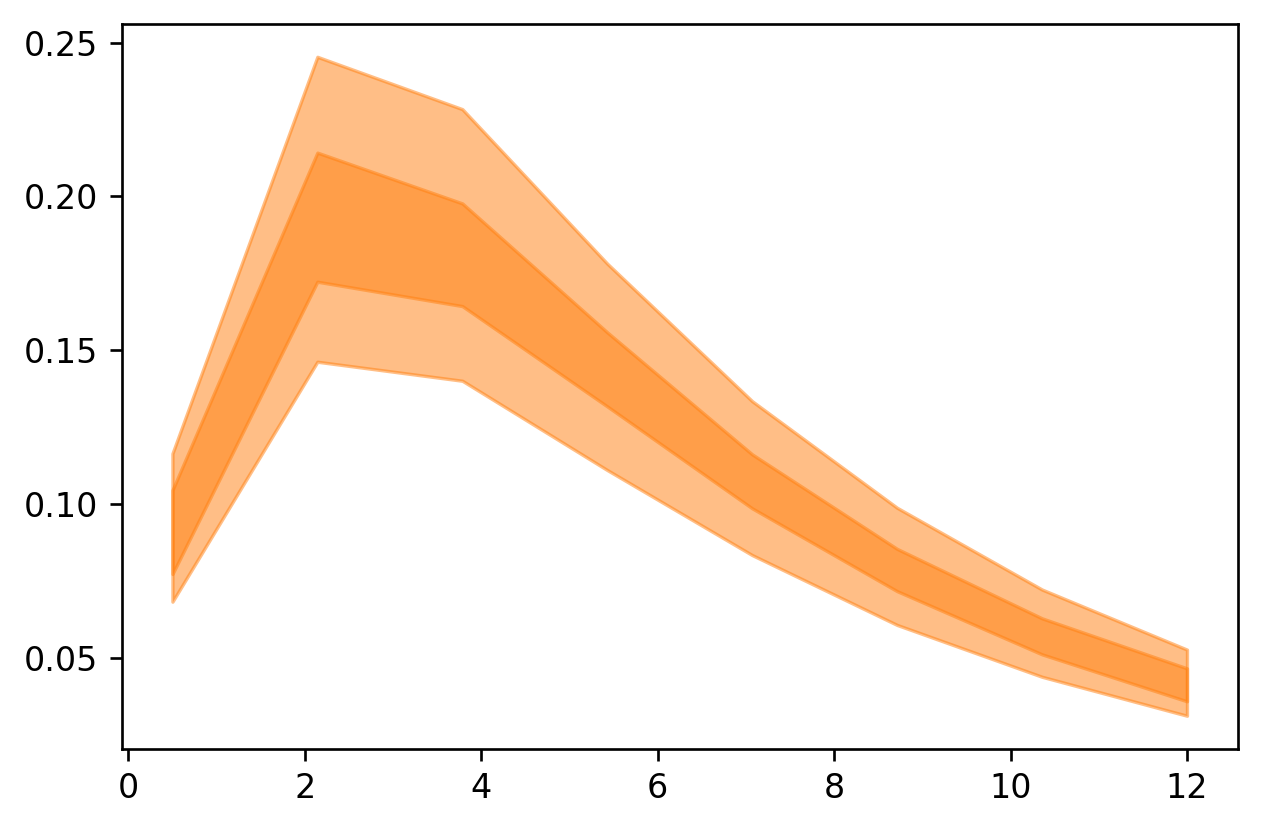

In [75]:
t = np.unique(times)
ix = subject_ids==0
y = strong_data.posterior.y_est[:,:, ix]
yppc = strong_data.posterior_predictive.Yobs[:,:, ix]
fig, ax = plt.subplots(dpi = 120)

az.plot_hpd(t,y, smooth=False, credible_interval=0.95, ax = ax)
az.plot_hpd(t,yppc, smooth=False, credible_interval=0.95, ax = ax)